In [39]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models , layers

In [40]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [46]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  '/kaggle/input/plant-village/PlantVillage',
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    seed=123,
    shuffle=True,
    class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy' ]
) 

Found 2152 files belonging to 3 classes.


In [56]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [61]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 2 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 2 0 0 0 2 1 1 0 0 0]


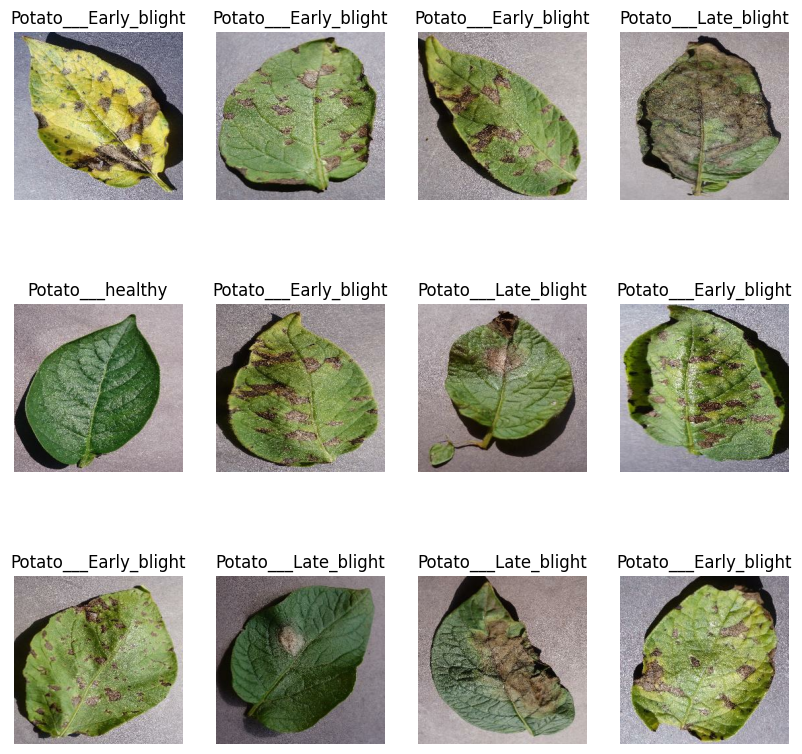

In [58]:
plt.figure(figsize = (10,10))

for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3 , 4 , i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [62]:
len(dataset)

68

In [63]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [64]:
train_df , val_df , test_df = get_dataset_partitions_tf(dataset)

In [65]:
len(train_df)

54

In [66]:
len(val_df)

6

In [67]:
len(test_df)

8

In [69]:
train_data = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [70]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1.0 / 255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [71]:
train_df = train_df.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [73]:
input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32 , (3,3) , activation = 'relu' , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64 , activation = 'relu'),
    layers.Dense(n_classes , activation = 'softmax')
])

model.build(input_shape = input_shape)


In [74]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
model.compile(optimizer = 'adam' , loss = 'SparseCategoricalCrossentropy' , metrics = ['accuracy'])

In [77]:
history = model.fit(train_data,
                   batch_size = BATCH_SIZE,
                   validation_data = val_data,
                   epochs = 10)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8926 - loss: 0.2517 - val_accuracy: 0.9479 - val_loss: 0.1344
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9217 - loss: 0.1986 - val_accuracy: 0.9375 - val_loss: 0.1430
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9515 - loss: 0.1268 - val_accuracy: 0.8229 - val_loss: 0.5852
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9153 - loss: 0.2334 - val_accuracy: 0.9740 - val_loss: 0.0845
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9760 - loss: 0.0691 - val_accuracy: 0.9896 - val_loss: 0.0373
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9874 - loss: 0.0377 - val_accuracy: 0.9844 - val_loss: 0.0361
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9818 - loss: 0.0478 - val_accuracy: 0.9948 - val_loss: 0.0228
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9632 - loss: 0.0845 - val_accuracy: 0.9896 - v

In [78]:
loss , accuracy = model.evaluate(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 572ms/step - accuracy: 0.9580 - loss: 0.0847


first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
predicted label: Potato___Late_blight


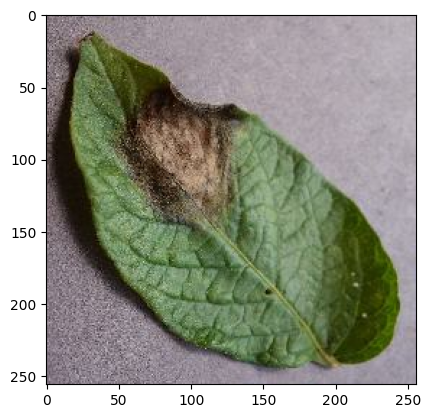

In [81]:
for images_batch, labels_batch in test_data.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [87]:
def predict(model , img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predict = model.predict(img_array)

    predicted_class = class_names[np.argmax(predict[0])]
    
    confidence = round(100 * (np.max(predict[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


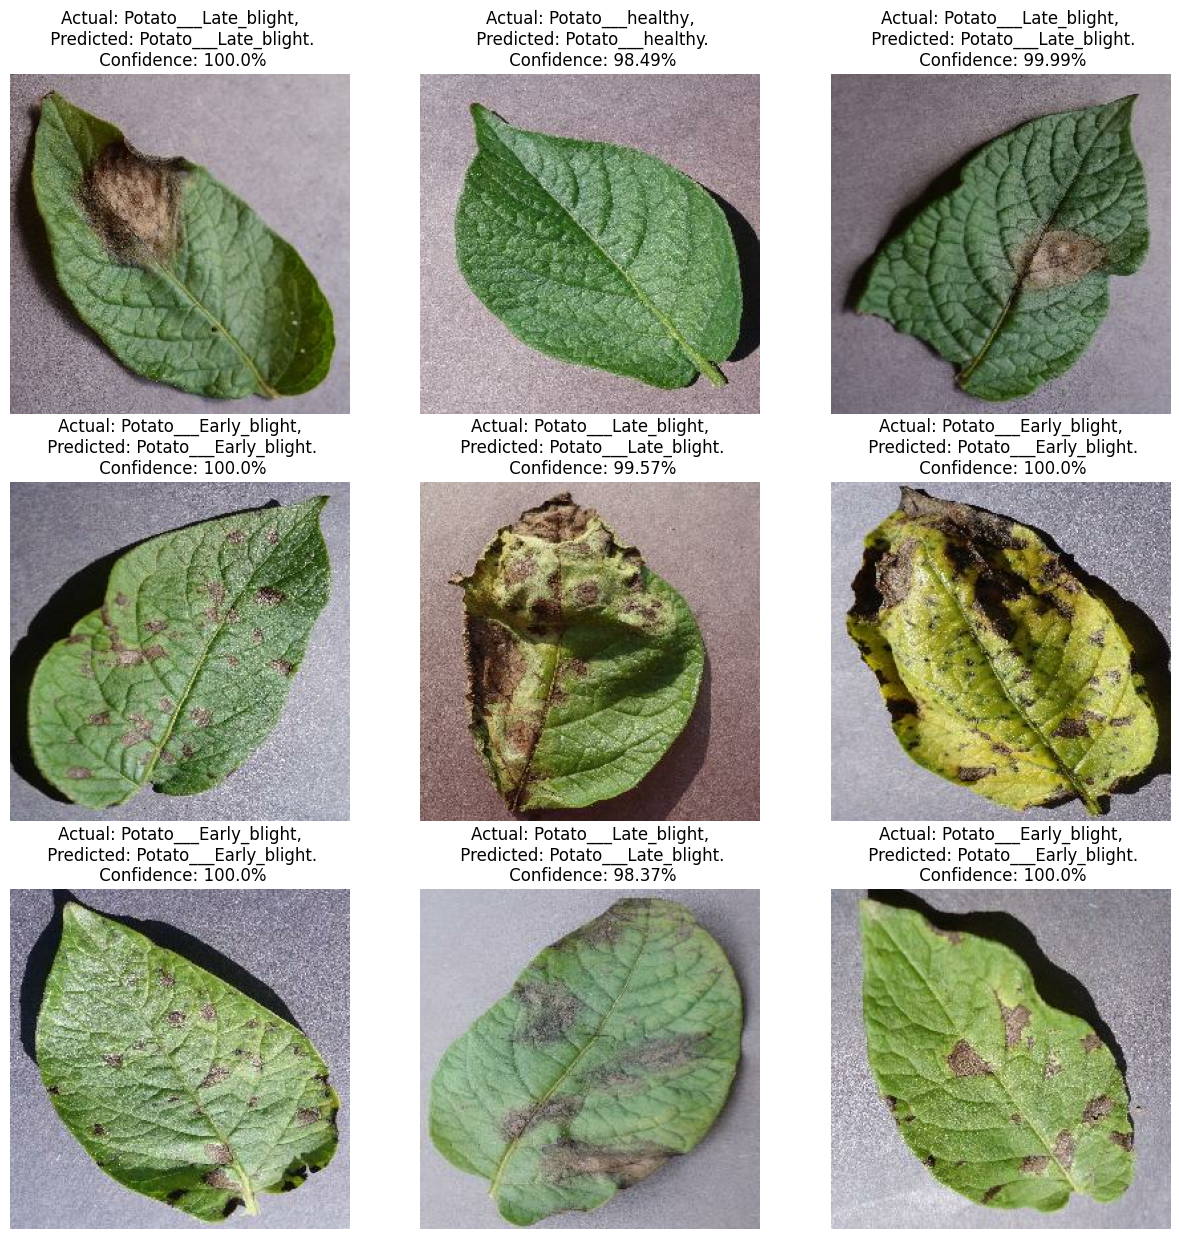

In [94]:
plt.figure(figsize = (15,15))

for images , labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3 , i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predict_class , confidence = predict(model , images[i].numpy())

        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predict_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
